In [4]:
import os
import sys
import glob
import scipy
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sns.set_palette("Set2")


## Read in information

In [5]:
PMdb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/SRA_metadata_v1.csv')
PLdb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/COVID_local_locations_v2.csv')

In [6]:
COdb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/COVID_genome_coverage_v2.csv')
Odb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/COVID_positional_coverage_v2.csv')
POdb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/COVID_genes_positional_v2.2.csv')


## Make QC figures relating various metadata to things

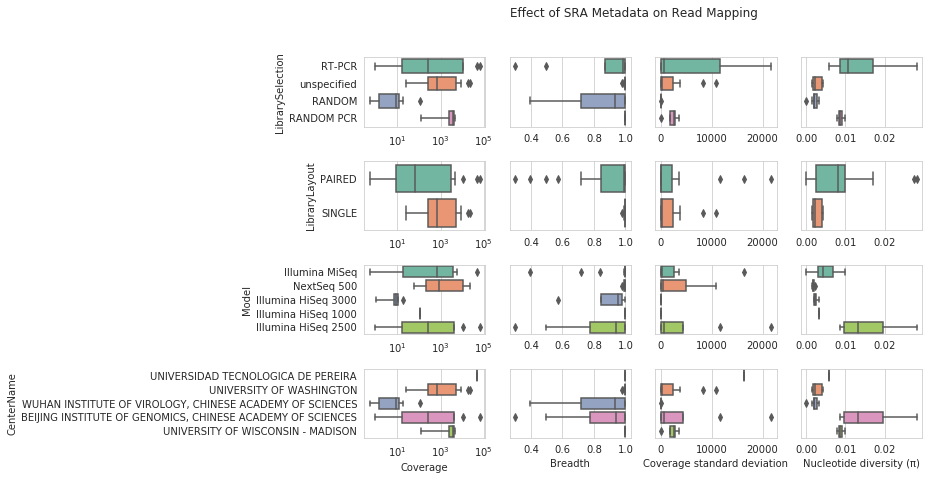

In [7]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/SRA_metadata_associations/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

fdb = pd.merge(PMdb, COdb, on='Run')
fdb['mean_microdiversity'] = 1 - fdb['mean_clonality']

m2m = {'coverage':'Coverage', 'breadth':'Breadth', 'std_cov':'Coverage standard deviation', 'mean_microdiversity':'Nucleotide diversity (π)'}
fdb = fdb.rename(columns=m2m)


VARIABLES = ['LibrarySource', 'LibraryStrategy', 'LibrarySelection', 'LibraryLayout', 'Model', 'CenterName']
VARIABLES = ['LibrarySelection', 'LibraryLayout', 'Model', 'CenterName']
METRICS = ['coverage', 'breadth', 'std_cov', 'mean_clonality']
METRICS = ['Coverage', 'Breadth', 'Coverage standard deviation', 'Nucleotide diversity (π)']

fig, axs = plt.subplots(
            len(VARIABLES), len(METRICS), figsize=(10, 7), gridspec_kw={"hspace": 0.5})


for m, met in enumerate(METRICS):
    for v, var in enumerate(VARIABLES):
        ax = axs[v][m]
        g = sns.boxplot(data=fdb, y=var, x=met, ax=ax)
        if m != 0:
            ax.set_ylabel('')
            ax.set_yticks([])
        if v != len(VARIABLES) - 1:
            ax.set_xlabel('')
            #ax.set_yticks([])
        if met in ['Coverage']:
            g.set_xscale("log")
        #plt.xticks(rotation=90)
plt.suptitle('Effect of SRA Metadata on Read Mapping')
plt.gcf().savefig(save_loc + 'QC_boxplots_v3.png'.format(met, var), bbox_inches='tight', dpi=200)
plt.show()
    

## Look at distributions

In [9]:
c2c = {'UNIVERSIDAD-TECNOLOGICA-DE-PEREIRA':'Univ_tech_Pereira', 
       'UNIVERSITY-OF-WASHINGTON':'Univ_Washington',
      'WUHAN-INSTITUTE-OF-VIROLOGY,':'Wuhan_inst_Virology',
      'BEIJING-INSTITUTE-OF-GENOMICS,':"Beijing_inst_genomics",
      "UNIVERSITY-OF-WISCONSIN--":'Univ_Wisconsin'}
PMdb['Center_name'] = ['-'.join(c.split()[:4]) for c in PMdb['CenterName']]
PMdb['Center_ID'] = PMdb['Center_name'].map(c2c)

14 by 5


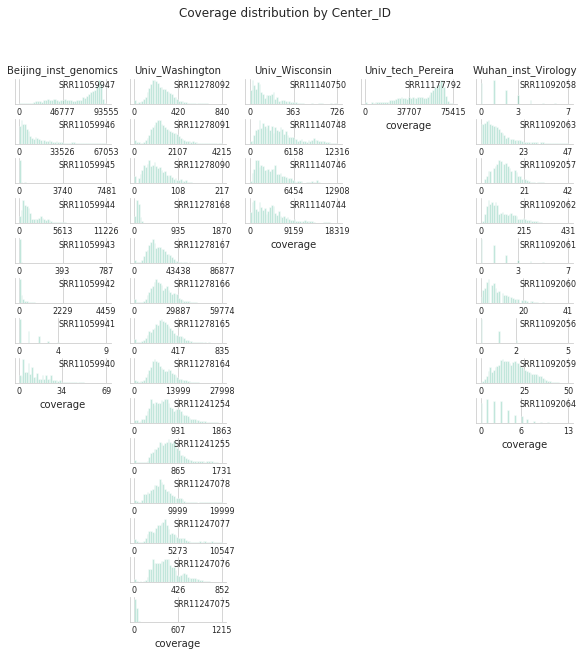

In [10]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Distributions/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

VARIABLES = ['LibrarySource', 'LibraryStrategy', 'LibrarySelection', 'LibraryLayout', 'Model', 'Center_ID']
VARIABLES = ['Center_ID']
for ORG_BY in VARIABLES:
    orgs = []
    org2samples = {}
    for org, db in PMdb.groupby(ORG_BY):
        org2samples[org] = db['Run'].tolist()
        #orgs.append("{0}\n({1} samples)".format(org, len(db)))
        orgs.append("{0}".format(org, len(db)))

    Y_LEN = len(PMdb[ORG_BY].unique())
    X_LEN = max([len(s) for o, s in org2samples.items()])
    print("{0} by {1}".format(X_LEN, Y_LEN))
    fig, axs = plt.subplots(X_LEN, Y_LEN, figsize=(10, 10), gridspec_kw={"hspace": 0.6})#, sharex=True, gridspec_kw={"hspace": 0.5})

    sns.set_style('white')
    CUR_Y = 0
    for org, samples in org2samples.items():
        CUR_X = 0
        for sample in samples:
            ax = axs[CUR_X][CUR_Y]
            Acov = Odb[Odb['Run'] == sample]['coverage']
            sns.distplot(Acov, kde=False, ax=ax)
            #ax.set_xlim(0, max(Acov))
            ax.set_yticks([])
            ax.set_xticks([0, int(np.mean([0, max(Acov)])), max(Acov)])
            ax.tick_params(axis='both', which='major', pad=0, labelsize=8)
            ax.set_xlabel('')
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.text(0.75, 0.75, sample, ha='center', va='center', transform=ax.transAxes, fontsize=8)
            CUR_X += 1
        
        ax.set_xlabel('coverage')
        while CUR_X < X_LEN:
            axs[CUR_X, CUR_Y].set_axis_off()
            CUR_X += 1
        CUR_Y += 1

    for ax, col in zip(axs[0], orgs):
        ax.set_title(col, fontdict={'fontsize': 10})


    plt.suptitle('Coverage distribution by {0}'.format(ORG_BY))
    plt.gcf().savefig(save_loc + 'CoverageDistrubution_{0}_v2.png'.format(ORG_BY), bbox_inches='tight', dpi=200)
    plt.show()
    break

14 by 5


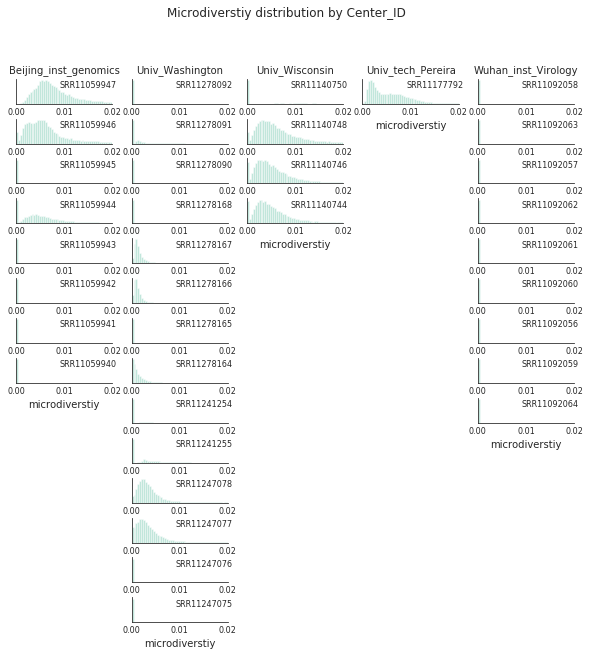

In [11]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Distributions/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

LIM = 0.02
VARIABLES = ['LibrarySource', 'LibraryStrategy', 'LibrarySelection', 'LibraryLayout', 'Model', 'Center_ID']
VARIABLES = ['Center_ID']
for ORG_BY in VARIABLES:
    orgs = []
    org2samples = {}
    for org, db in PMdb.groupby(ORG_BY):
        org2samples[org] = db['Run'].tolist()
        #orgs.append("{0}\n({1} samples)".format(org, len(db)))
        orgs.append("{0}".format(org, len(db)))

    Y_LEN = len(PMdb[ORG_BY].unique())
    X_LEN = max([len(s) for o, s in org2samples.items()])
    print("{0} by {1}".format(X_LEN, Y_LEN))
    fig, axs = plt.subplots(X_LEN, Y_LEN, figsize=(10, 10), gridspec_kw={"hspace": 0.6})#, sharex=True, gridspec_kw={"hspace": 0.5})

    sns.set_style('white')
    CUR_Y = 0
    for org, samples in org2samples.items():
        CUR_X = 0
        for sample in samples:
            ax = axs[CUR_X][CUR_Y]
            Acov = Odb[Odb['Run'] == sample]['microdiversity'].dropna()
            Acov = Acov[(Acov <= LIM)]
            sns.distplot(Acov, kde=False, ax=ax, bins=50, hist_kws={"range": [0, LIM]})
            ax.set_xlim(0, LIM)
#             sns.distplot(Acov, kde=False, ax=ax)
#             ax.set_xlim(0, max(Acov))
            ax.set_xticks([0, LIM/2, LIM])
            ax.set_yticks([])
    
            #ax.set_xticks([0, int(np.mean([0, max(Acov)])), max(Acov)])
            ax.tick_params(axis='both', which='major', pad=0, labelsize=8)
            ax.set_xlabel('')
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.text(0.75, 0.75, sample, ha='center', va='center', transform=ax.transAxes, fontsize=8)
            CUR_X += 1
        
        ax.set_xlabel('microdiverstiy')
        while CUR_X < X_LEN:
            axs[CUR_X, CUR_Y].set_axis_off()
            CUR_X += 1
        CUR_Y += 1

    for ax, col in zip(axs[0], orgs):
        ax.set_title(col, fontdict={'fontsize': 10})


    plt.suptitle('Microdiverstiy distribution by {0}'.format(ORG_BY))
    plt.gcf().savefig(save_loc + 'MicrodiversityDistrubution_{0}_v2.png'.format(ORG_BY), bbox_inches='tight', dpi=200)
    plt.show()
    

14 by 5


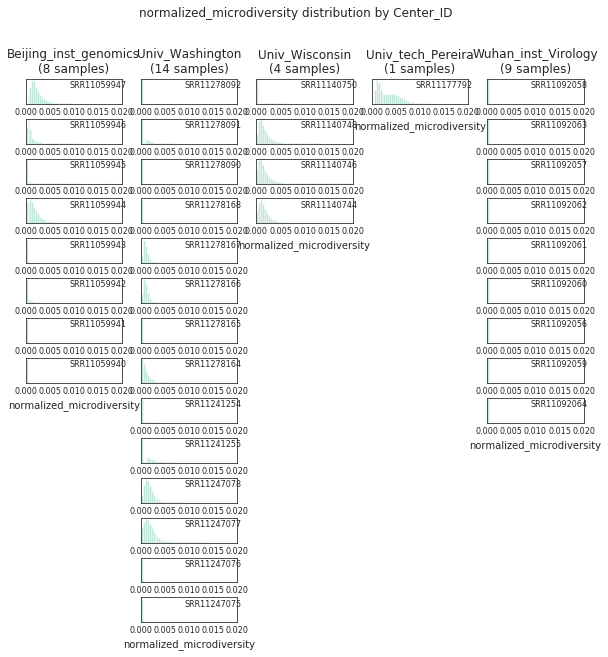

In [12]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Distributions/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

LIM = 0.02
VARIABLES = ['LibrarySource', 'LibraryStrategy', 'LibrarySelection', 'LibraryLayout', 'Model', 'Center_ID']
VARIABLES = ['Center_ID']
for ORG_BY in VARIABLES:
    orgs = []
    org2samples = {}
    for org, db in PMdb.groupby(ORG_BY):
        org2samples[org] = db['Run'].tolist()
        orgs.append("{0}\n({1} samples)".format(org, len(db)))

    Y_LEN = len(PMdb[ORG_BY].unique())
    X_LEN = max([len(s) for o, s in org2samples.items()])
    print("{0} by {1}".format(X_LEN, Y_LEN))
    fig, axs = plt.subplots(X_LEN, Y_LEN, figsize=(10, 10), gridspec_kw={"hspace": 0.6})#, sharex=True, gridspec_kw={"hspace": 0.5})

    sns.set_style('white')
    CUR_Y = 0
    for org, samples in org2samples.items():
        CUR_X = 0
        for sample in samples:
            ax = axs[CUR_X][CUR_Y]
            Acov = Odb[Odb['Run'] == sample]['normalized_microdiversity'].dropna()
            Acov = Acov[(Acov <= LIM)]
            sns.distplot(Acov, kde=False, ax=ax, bins=50, hist_kws={"range": [0, LIM]})
            ax.set_xlim(0, LIM)
#             sns.distplot(Acov, kde=False, ax=ax)
#             ax.set_xlim(0, max(Acov))
            ax.set_yticks([])
            #ax.set_xticks([0, int(np.mean([0, max(Acov)])), max(Acov)])
            ax.tick_params(axis='both', which='major', pad=0, labelsize=8)
            ax.set_xlabel('')
            plt.text(0.75, 0.75, sample, ha='center', va='center', transform=ax.transAxes, fontsize=8)
            CUR_X += 1
        
        ax.set_xlabel('normalized_microdiversity')
        while CUR_X < X_LEN:
            axs[CUR_X, CUR_Y].set_axis_off()
            CUR_X += 1
        CUR_Y += 1

    for ax, col in zip(axs[0], orgs):
        ax.set_title(col)


    plt.suptitle('normalized_microdiversity distribution by {0}'.format(ORG_BY))
    plt.gcf().savefig(save_loc + 'NormalizedMicrodiversityDistrubution_{0}_v2.png'.format(ORG_BY), bbox_inches='tight', dpi=200)
    plt.show()
    

## You need just such insane coverage to have a nice microdiversity distribution... 

# Positional microdiversity

## 1) QC to show that overall, the third position has higher microdiversity. Also choose a metric

I Think I like normalized_microdiversity

In [9]:
fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= 50]
fdb = fdb[~fdb['orf_position'].isna()]
fdb['orf_position'] = fdb['orf_position'].astype(int)

for ON in ['coverage_x', 'microdiversity', 'normalized_microdiversity',	'rarefied_microdiversity',	'normalized_rarefied_microdiversity']:
    print("!!! {0} !!!".format(ON))
    for i, orf1 in enumerate([0, 1, 2]):
        for j, orf2 in enumerate([0, 1, 2]):
            if i >= j:
                continue
            stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == orf1][ON].tolist(), fdb[fdb['orf_position'] == orf2][ON].tolist())
            print("{0} vs {1} - p = {2:.2E}".format(orf1, orf2, p))
    print()

!!! coverage_x !!!
0 vs 1 - p = 9.78E-01
0 vs 2 - p = 9.66E-01
1 vs 2 - p = 9.88E-01

!!! microdiversity !!!
0 vs 1 - p = 1.06E-05
0 vs 2 - p = 3.93E-22
1 vs 2 - p = 1.97E-06

!!! normalized_microdiversity !!!
0 vs 1 - p = 1.09E-05
0 vs 2 - p = 1.72E-20
1 vs 2 - p = 1.80E-06

!!! rarefied_microdiversity !!!
0 vs 1 - p = 4.54E-01
0 vs 2 - p = 5.44E-05
1 vs 2 - p = 2.81E-02

!!! normalized_rarefied_microdiversity !!!
0 vs 1 - p = 7.65E-01
0 vs 2 - p = 7.65E-03
1 vs 2 - p = 3.69E-02



1 vs 2 - p = 1.15E-05
1 vs 3 - p = 4.33E-20
2 vs 3 - p = 1.38E-06


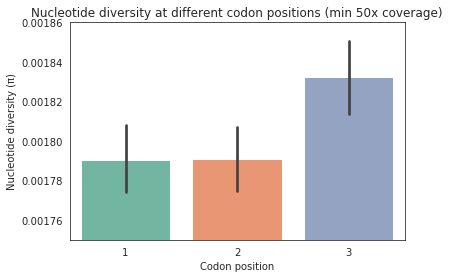

In [13]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Results/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

ON = 'normalized_microdiversity'
MIN_COV = 50

fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= MIN_COV]
fdb = fdb[~fdb['orf_position'].isna()]
fdb = fdb.drop_duplicates(subset=['Run', 'position'])
fdb['orf_position'] = fdb['orf_position'].astype(int) + 1

sns.barplot(data=fdb, x='orf_position', y=ON)#, ci=None)#, showfliers=False)
plt.ylim(0.00175, 0.00186)
plt.xlabel('Codon position')
plt.ylabel('Nucleotide diversity (π)')

for i, orf1 in enumerate([1, 2, 3]):
    for j, orf2 in enumerate([1, 2, 3]):
        if i >= j:
            continue
        stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == orf1][ON].tolist(), fdb[fdb['orf_position'] == orf2][ON].tolist())
        print("{0} vs {1} - p = {2:.2E}".format(orf1, orf2, p))
plt.title('Nucleotide diversity at different codon positions (min {0}x coverage)'.format(MIN_COV))
plt.gcf().savefig(save_loc + 'CodonNormMicrodiversity_min_{0}_v3.png'.format(MIN_COV), bbox_inches='tight', dpi=200)

plt.show()

        

1 vs 2 - p = 5.48E-06
1 vs 3 - p = 2.30E-21
2 vs 3 - p = 9.95E-07


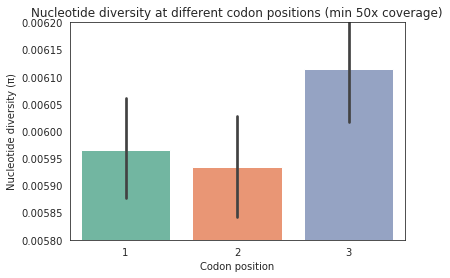

In [18]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Results/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

#ON = 'normalized_microdiversity'
ON = 'microdiversity'
MIN_COV = 50

fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= MIN_COV]
fdb = fdb[~fdb['orf_position'].isna()]
fdb = fdb.drop_duplicates(subset=['Run', 'position'])
fdb['orf_position'] = fdb['orf_position'].astype(int) + 1

sns.barplot(data=fdb, x='orf_position', y=ON)#, ci=None)#, showfliers=False)
plt.ylim(0.0058, 0.0062)
plt.xlabel('Codon position')
plt.ylabel('Nucleotide diversity (π)')

for i, orf1 in enumerate([1, 2, 3]):
    for j, orf2 in enumerate([1, 2, 3]):
        if i >= j:
            continue
        stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == orf1][ON].tolist(), fdb[fdb['orf_position'] == orf2][ON].tolist())
        print("{0} vs {1} - p = {2:.2E}".format(orf1, orf2, p))
plt.title('Nucleotide diversity at different codon positions (min {0}x coverage)'.format(MIN_COV))
plt.gcf().savefig(save_loc + 'CodonMicrodiversity_min_{0}_v3.png'.format(MIN_COV), bbox_inches='tight', dpi=200)

plt.show()

        

1 vs 2 - p = 6.53E-14
1 vs 3 - p = 2.92E-57
2 vs 3 - p = 2.32E-17


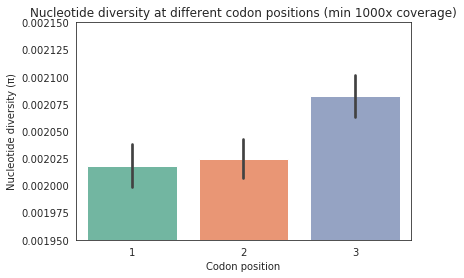

In [11]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Results/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

ON = 'normalized_microdiversity'
MIN_COV = 1000

fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= MIN_COV]
fdb = fdb[~fdb['orf_position'].isna()]
fdb['orf_position'] = fdb['orf_position'].astype(int) + 1
fdb = fdb.drop_duplicates(subset=['Run', 'position'])

sns.barplot(data=fdb, x='orf_position', y=ON)#, ci=None)#, showfliers=False)
plt.ylim(0.00195, 0.00215)
plt.xlabel('Codon position')
plt.ylabel('Nucleotide diversity (π)')

for i, orf1 in enumerate([1, 2, 3]):
    for j, orf2 in enumerate([1, 2, 3]):
        if i >= j:
            continue
        stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == orf1][ON].tolist(), fdb[fdb['orf_position'] == orf2][ON].tolist())
        print("{0} vs {1} - p = {2:.2E}".format(orf1, orf2, p))
plt.title('Nucleotide diversity at different codon positions (min {0}x coverage)'.format(MIN_COV))
plt.gcf().savefig(save_loc + 'CodonMicrodiversity_min_{0}_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)

plt.show()

        

## 2) On a gene-by-gene level, which ones have this signal

In [20]:
ON = 'normalized_microdiversity'
MIN_COV = 50

fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= MIN_COV]
fdb = fdb[~fdb['orf_position'].isna()]
fdb['orf_position'] = fdb['orf_position'].astype(int) + 1
Fdb = fdb.copy()

# Individual genes, all samples
table = defaultdict(list)
for g, db in fdb.groupby('protein'):
    stat_b, p_b = scipy.stats.ranksums(db[db['orf_position'] == 1][ON].tolist(), db[db['orf_position'] == 2][ON].tolist())
    stat, p = scipy.stats.ranksums(db[db['orf_position'] == 3][ON].tolist(), db[db['orf_position'] != 3][ON].tolist())
    n = len(db[db['orf_position'] == 2][ON].tolist())
    
    table['gene'].append(g)
    table['1_2'].append(p_b)
    table['3'].append(p)
    table['n'].append(n)
    table['min_cov'].append(MIN_COV)
    table['Run'].append('all_{0}'.format(len(fdb['Run'].unique())))

# All genes, all samples
fdb = fdb.drop_duplicates(subset=['Run', 'position'])
stat_b, p_b = scipy.stats.ranksums(fdb[fdb['orf_position'] == 1][ON].tolist(), fdb[fdb['orf_position'] == 2][ON].tolist())
stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == 3][ON].tolist(), fdb[fdb['orf_position'] != 3][ON].tolist())
n = len(fdb[fdb['orf_position'] == 2][ON].tolist())
    
table['gene'].append('all')
table['1_2'].append(p_b)
table['3'].append(p)
table['n'].append(n)
table['min_cov'].append(MIN_COV)
table['Run'].append('all_{0}'.format(len(fdb['Run'].unique())))

# Invidivual Runs
for run, fdb in Fdb.groupby('Run'):
    for g, db in fdb.groupby('protein'):
        stat_b, p_b = scipy.stats.ranksums(db[db['orf_position'] == 1][ON].tolist(), db[db['orf_position'] == 2][ON].tolist())
        stat, p = scipy.stats.ranksums(db[db['orf_position'] == 3][ON].tolist(), db[db['orf_position'] != 3][ON].tolist())
        n = len(db[db['orf_position'] == 2][ON].tolist())

        table['gene'].append(g)
        table['1_2'].append(p_b)
        table['3'].append(p)
        table['n'].append(n)
        table['min_cov'].append(MIN_COV)
        table['Run'].append(run)

    # All genes, all samples
    fdb = fdb.drop_duplicates(subset=['Run', 'position'])
    stat_b, p_b = scipy.stats.ranksums(fdb[fdb['orf_position'] == 1][ON].tolist(), fdb[fdb['orf_position'] == 2][ON].tolist())
    stat, p = scipy.stats.ranksums(fdb[fdb['orf_position'] == 3][ON].tolist(), fdb[fdb['orf_position'] != 3][ON].tolist())
    n = len(fdb[fdb['orf_position'] == 2][ON].tolist())

    table['gene'].append('all')
    table['1_2'].append(p_b)
    table['3'].append(p)
    table['n'].append(n)
    table['min_cov'].append(MIN_COV)
    table['Run'].append(run)
    
ORdb = pd.DataFrame(table)
#ORdb.sort_values('3')


In [21]:
tdb = ORdb[ORdb['Run'].str.contains('all')]
tdb['sig'] = [(x < 0.01) & (y > x) for x, y in zip(tdb['3'], tdb['1_2'])]
tdb.sort_values('n')

/home/mattolm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gene,1_2,3,n,min_cov,Run,sig
25,YP_009725312.1,0.439664,1.728649e-01,312,50,all_24,False
3,ORF10,0.286846,7.935748e-01,1056,50,all_24,False
7,ORF7b,0.192443,4.866257e-01,1056,50,all_24,False
5,ORF6,0.036836,6.533909e-01,1488,50,all_24,False
0,E,0.968965,3.512155e-01,1824,50,all_24,False
16,YP_009725303.1,0.177628,2.475459e-01,1992,50,all_24,False
18,YP_009725305.1,0.764269,8.788602e-01,2712,50,all_24,False
8,ORF8,0.009520,3.698776e-01,2928,50,all_24,False
6,ORF7a,0.452849,2.713052e-01,2928,50,all_24,False
19,YP_009725306.1,0.534730,9.991689e-02,3336,50,all_24,False


## It's really just that longer genes have more signal...

In [33]:
tdb = ORdb[ORdb['gene'] == 'all']
tdb['sample_coverage'] = ORdb['Run'].map(COdb.set_index('Run')['coverage'].to_dict())
THING = 'Center_ID'
tdb[THING] = ORdb['Run'].map(PMdb.set_index('Run')[THING].to_dict())
tdb['sig'] = [(x < 0.01) & (y > x) for x, y in zip(tdb['3'], tdb['1_2'])]
tdb.sort_values('sample_coverage')

/home/mattolm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mattolm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mattolm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,gene,1_2,3,n,min_cov,Run,sample_coverage,Center_ID,sig
485,all,8.389198e-01,9.016507e-01,9753,50,SRR11278090,56.407819,Univ_Washington,False
674,all,8.483308e-01,7.139799e-01,9753,50,SRR11278168,80.702438,Univ_Washington,False
188,all,8.971874e-01,1.481248e-01,9753,50,SRR11092062,110.238070,Wuhan_inst_Virology,False
296,all,6.406419e-01,8.808782e-02,9753,50,SRR11140750,124.305688,Univ_Wisconsin,False
107,all,1.864193e-17,1.035889e-22,9753,50,SRR11059945,234.819048,Beijing_inst_genomics,True
539,all,9.815454e-01,4.403926e-01,9753,50,SRR11278092,242.371066,Univ_Washington,False
53,all,3.261836e-02,3.900315e-01,9753,50,SRR11059942,275.427850,Beijing_inst_genomics,False
593,all,9.161507e-01,5.168124e-01,9753,50,SRR11278165,284.614420,Univ_Washington,False
404,all,8.666281e-01,5.570970e-01,9753,50,SRR11247076,319.955623,Univ_Washington,False
350,all,5.612833e-01,5.323795e-01,9753,50,SRR11241254,681.345985,Univ_Washington,False


In [34]:
tdb['Center_ID'].value_counts()

Univ_Washington          13
Beijing_inst_genomics     5
Univ_Wisconsin            4
Wuhan_inst_Virology       1
Univ_tech_Pereira         1
Name: Center_ID, dtype: int64

## By eye, it also just looks like coverage is important for detecting this particular signal on a run level; that's good enough for me.

## 3) Identify genes with consistantly high / low microdiversity

In [23]:
ON = 'normalized_microdiversity'
MIN_COV = 50

fdb = pd.merge(Odb, POdb, on='position', how='left').merge(COdb, how='left', on='Run')
fdb = fdb[fdb['coverage_y'] >= MIN_COV]

table = defaultdict(list)
for run, rdb in fdb.groupby('Run'):
    for gene, db in rdb.groupby('protein'):
        table['Run'].append(run)
        table['gene'].append(gene)
        table['coverage'].append(db['coverage_x'].mean())
        table[ON].append(db[ON].mean())
        
    for gene, db in rdb.groupby('gene'):
        table['Run'].append(run)
        table['gene'].append(gene)
        table['coverage'].append(db['coverage_x'].mean())
        table[ON].append(db[ON].mean())

run = 'all'
rdb = fdb
for gene, db in rdb.groupby('protein'):
    table['Run'].append(run)
    table['gene'].append(gene)
    table['coverage'].append(db['coverage_x'].mean())
    table[ON].append(db[ON].mean())

for gene, db in rdb.groupby('gene'):
    table['Run'].append(run)
    table['gene'].append(gene)
    table['coverage'].append(db['coverage_x'].mean())
    table[ON].append(db[ON].mean())

MGdb = pd.DataFrame(table)
    
# Add rank order
dbs = {}
ITEMS = [ON, 'coverage']
for item in ITEMS:
    dbs[item] = []
for run, db in MGdb.groupby('Run'):
    for item in ITEMS:
        db = db.sort_values(item).reset_index(drop=True)
        db = db.reset_index(drop=False).rename(columns={'index':'{0}_rank'.format(item)})
        dbs[item].append(db)
        
for item in ITEMS:
    db = pd.concat(dbs[item]).reset_index(drop=True)
    MGdb = pd.merge(MGdb, db, how='left', on=list(MGdb.columns))

MGdb

,Run,gene,coverage,normalized_microdiversity,normalized_microdiversity_rank,coverage_rank
0,SRR11059942,E,146.021930,0.001727,5,12
1,SRR11059942,M,100.140508,0.001882,7,10
2,SRR11059942,N,490.659524,0.002353,16,25
3,SRR11059942,ORF10,483.774436,0.002464,19,24
4,SRR11059942,ORF3a,187.567633,0.003718,25,15
...,...,...,...,...,...,...
720,all,YP_009725311.1,9716.783417,0.001535,1,22
721,all,YP_009725312.1,7951.755342,0.000928,0,11
722,all,3'UTR,4739.912664,0.008741,28,1
723,all,5'UTR,1779.936478,0.007711,27,0


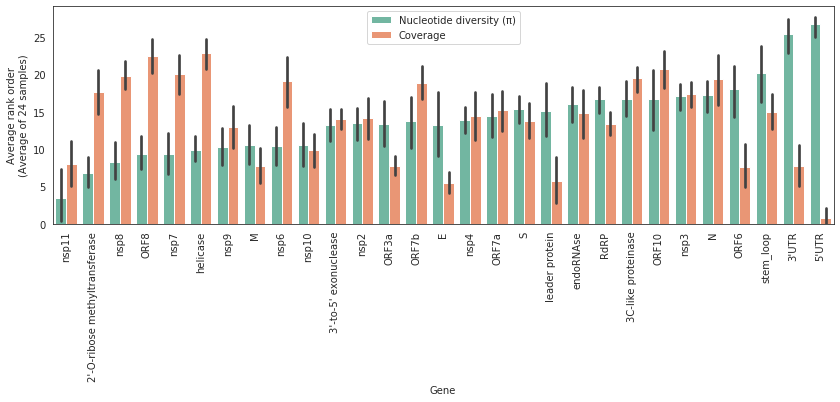

In [24]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Results/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

## Plot
fdb = MGdb.copy()

g2n = {}
for g, n in dict(POdb.set_index('protein')['protein_name'].to_dict()).items():
    g2n[g] = n
for g, n in dict(POdb.set_index('gene')['gene_name'].to_dict()).items():
    g2n[g] = n

fdb['name'] = fdb['gene'].map(g2n)

# Get the sort order
order = fdb.groupby('name')['normalized_microdiversity_rank'].mean().to_frame().sort_values('normalized_microdiversity_rank').reset_index()['name'].tolist()

# Melt
fdb = fdb.melt(id_vars=['name', 'Run'], value_vars=[i + '_rank' for i in ITEMS])
fdb = fdb[fdb['Run'] != 'all']

# Sort
fdb['name'] = fdb['name'].astype('category')
fdb['name'].cat.reorder_categories(order, inplace=True)
fdb = fdb.sort_values('name')

# Rename
v2v = {'normalized_microdiversity_rank':'Nucleotide diversity (π)', 'coverage_rank':'Coverage'}
fdb['variable'] = fdb['variable'].map(v2v)

# Plot
sns.barplot(data=fdb, x='name', y='value', hue='variable')#, ci=None)
plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel("Average rank order\n(Average of {0} samples)".format(len(fdb['Run'].unique())))
plt.legend(title='')
plt.gcf().set_size_inches(14, 4)
plt.gcf().savefig(save_loc + 'GeneMicrodiversity_RankOrder_Coverage_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
plt.show()


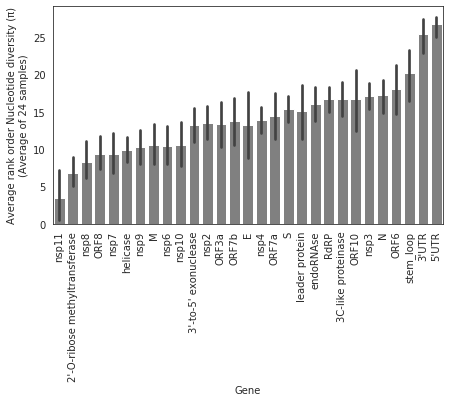

In [25]:
save_loc = '/home/mattolm/user_data/Covid_19/Figures/Results/'
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

## Plot
fdb = MGdb.copy()

g2n = {}
for g, n in dict(POdb.set_index('protein')['protein_name'].to_dict()).items():
    g2n[g] = n
for g, n in dict(POdb.set_index('gene')['gene_name'].to_dict()).items():
    g2n[g] = n

fdb['name'] = fdb['gene'].map(g2n)

# Get the sort order
order = fdb.groupby('name')['normalized_microdiversity_rank'].mean().to_frame().sort_values('normalized_microdiversity_rank').reset_index()['name'].tolist()

# Melt
fdb = fdb.melt(id_vars=['name', 'Run'], value_vars=[i + '_rank' for i in ITEMS])
fdb = fdb[fdb['Run'] != 'all']

# Sort
fdb['name'] = fdb['name'].astype('category')
fdb['name'].cat.reorder_categories(order, inplace=True)
fdb = fdb.sort_values('name')

# Rename
v2v = {'normalized_microdiversity_rank':'Nucleotide diversity (π)', 'coverage_rank':'Coverage'}
fdb['variable'] = fdb['variable'].map(v2v)

# Plot
fdb = fdb[fdb['variable'] == 'Nucleotide diversity (π)']
sns.barplot(data=fdb, x='name', y='value', color='grey')#, ci=None)
plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel("Average rank order Nucleotide diversity (π)\n(Average of {0} samples)".format(len(fdb['Run'].unique())))
#plt.legend(title='')
plt.gcf().set_size_inches(7, 4)
plt.gcf().savefig(save_loc + 'GeneMicrodiversity_RankOrder_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
plt.show()


# Incorporate interpatient nucleotide diversity

In [100]:
IPdb = pd.read_csv('/home/mattolm/user_data/GitRepos/covid19_population_genomics/data/interpatient/nucleotide_diversity.txt', sep='\t', names=['position', 'diversity'])
IPdb['position'] = IPdb['position'] - 1
IPdb['diversity'].mean()

0.00028213073193101516

In [101]:
ON = 'diversity'
MIN_COV = 50

rdb = pd.merge(IPdb, POdb, how='left', on='position')

table = defaultdict(list)
for gene, db in rdb.groupby('protein'):
    table['Run'].append(run)
    table['gene'].append(gene)
    table[ON].append(db[ON].mean())

for gene, db in rdb.groupby('gene'):
    table['Run'].append(run)
    table['gene'].append(gene)
    table[ON].append(db[ON].mean())

PGdb = pd.DataFrame(table)

# Add rank order
dbs = {}
ITEMS = [ON]
for item in ITEMS:
    dbs[item] = []
db = PGdb
for item in ITEMS:
    db = db.sort_values(item).reset_index(drop=True)
    db = db.reset_index(drop=False).rename(columns={'index':'{0}_rank'.format(item)})
    dbs[item].append(db)
        
for item in ITEMS:
    db = pd.concat(dbs[item]).reset_index(drop=True)
    PGdb = pd.merge(PGdb, db, how='left', on=list(PGdb.columns))

PGdb.head()

,Run,gene,diversity,diversity_rank
0,all,E,0.000249,19
1,all,M,0.000085,9
2,all,N,0.000344,22
3,all,ORF10,0.000851,24
4,all,ORF3a,0.000244,18


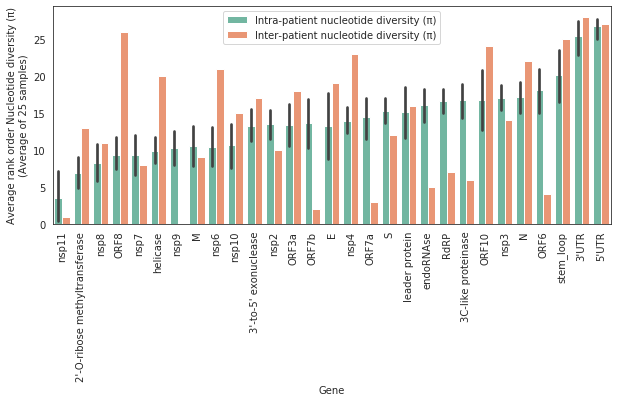

In [103]:
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

## Plot
fdb = MGdb.copy()
ITEMS = ['normalized_microdiversity', 'coverage']

g2n = {}
for g, n in dict(POdb.set_index('protein')['protein_name'].to_dict()).items():
    g2n[g] = n
for g, n in dict(POdb.set_index('gene')['gene_name'].to_dict()).items():
    g2n[g] = n

fdb['name'] = fdb['gene'].map(g2n)

# Get the sort order
order = fdb.groupby('name')['normalized_microdiversity_rank'].mean().to_frame().sort_values('normalized_microdiversity_rank').reset_index()['name'].tolist()

# Melt
fdb = fdb.melt(id_vars=['name', 'Run'], value_vars=[i + '_rank' for i in ITEMS])
fdb = fdb[fdb['Run'] != 'all']

# Add interpatient diversity
ffdb = PGdb.copy()
ffdb['name'] = ffdb['gene'].map(g2n)
ffdb['variable'] = 'Inter-patient nucleotide diversity (π)'
ffdb = ffdb[['name', 'variable', 'diversity_rank']].rename(columns={'diversity_rank':'value'})
fdb = pd.concat([fdb, ffdb])

# Sort
fdb['name'] = fdb['name'].astype('category')
fdb['name'].cat.reorder_categories(order, inplace=True)
fdb = fdb.sort_values('name')

# Rename
v2v = {'normalized_microdiversity_rank':'Intra-patient nucleotide diversity (π)', 'coverage_rank':'Coverage', 'Inter-patient nucleotide diversity (π)':'Inter-patient nucleotide diversity (π)'}
fdb['variable'] = fdb['variable'].map(v2v)

# Remove coverage
fdb = fdb[fdb['variable'] != 'Coverage']

# Plot
sns.barplot(data=fdb, x='name', y='value', hue='variable')#, ci=None)
plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel("Average rank order Nucleotide diversity (π)\n(Average of {0} samples)".format(len(fdb['Run'].unique())))
plt.legend(title='')
plt.gcf().set_size_inches(10, 4)
plt.gcf().savefig(save_loc + 'GeneMicrodiversity_RankOrder_interIntra_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
# plt.show()


# Scatter plot

## Median value

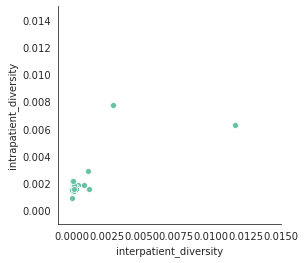

In [29]:
# Get median average intra-patient gene diversity
fdb = MGdb.copy()
fdb = fdb[fdb['Run'] != 'all']
fdb = fdb.groupby('gene')['normalized_microdiversity'].median().to_frame().reset_index(drop=False).rename(columns={'normalized_microdiversity':'intrapatient_diversity'})

# Get average inter-patient diversity
ffdb = PGdb
ffdb = ffdb[['gene', 'diversity']].rename(columns={'diversity':'interpatient_diversity'})

# Merge
fdb = pd.merge(fdb, ffdb, on='gene', how='outer')

# Plot
#LIM = 0.015
LIM = 0.015
sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity')#, hue='gene')
#plt.gca().get_legend().remove()
plt.xlim(-0.001, LIM)
plt.ylim(-0.001, LIM)
plt.gcf().set_size_inches(4, 4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


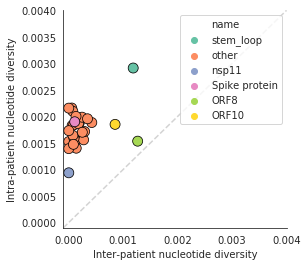

In [30]:
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

g2c = {'S':'Spike protein', 'ORF10':'ORF10', 'ORF8':'ORF8', 'stem_loop':'stem_loop', "YP_009725312.1":'nsp11'}
fdb['name'] = fdb['gene'].map(g2c).fillna('other')
fdb = fdb.sort_values('name', ascending=False)

LIM = 0.004
NLIM = -0.0001
sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity', hue='name', s=100, edgecolor='black')
#plt.legend(name="Gene name")
plt.xlim(NLIM, LIM)
plt.ylim(NLIM, LIM)
plt.gcf().set_size_inches(4, 4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([NLIM,LIM], [NLIM,LIM], c='lightgrey', ls='--')#, dpi=200)
plt.xlabel('Inter-patient nucleotide diversity')
plt.ylabel('Intra-patient nucleotide diversity')

plt.gcf().savefig(save_loc + 'GeneMicrodiversity_scatter_interIntra_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
plt.show()

## Average value

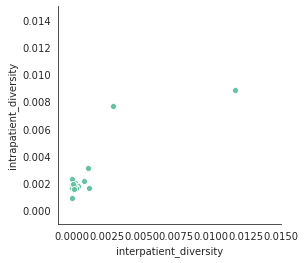

In [31]:
# Get average average intra-patient gene diversity
fdb = MGdb.copy()
fdb = fdb[fdb['Run'] != 'all']
fdb = fdb.groupby('gene')['normalized_microdiversity'].mean().to_frame().reset_index(drop=False).rename(columns={'normalized_microdiversity':'intrapatient_diversity'})

# Get average inter-patient diversity
ffdb = PGdb
ffdb = ffdb[['gene', 'diversity']].rename(columns={'diversity':'interpatient_diversity'})

# Merge
fdb = pd.merge(fdb, ffdb, on='gene', how='outer')

# Plot
#LIM = 0.015
LIM = 0.015
sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity')#, hue='gene')
#plt.gca().get_legend().remove()
plt.xlim(-0.001, LIM)
plt.ylim(-0.001, LIM)
plt.gcf().set_size_inches(4, 4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


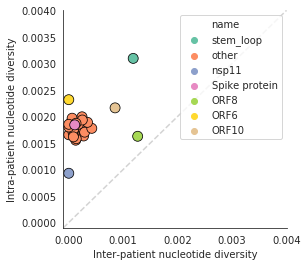

In [41]:
save_loc = '/home/mattolm/user_data/GitRepos/covid19_population_genomics/results/'

g2c = {'S':'Spike protein', 'ORF10':'ORF10', 'ORF8':'ORF8', 'stem_loop':'stem_loop', "YP_009725312.1":'nsp11', 'ORF6':'ORF6'}
fdb['name'] = fdb['gene'].map(g2c).fillna('other')
fdb = fdb.sort_values('name', ascending=False)

LIM = 0.004
NLIM = -0.0001
sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity', hue='name', s=100, edgecolor='black')
#plt.legend(name="Gene name")
plt.xlim(NLIM, LIM)
plt.ylim(NLIM, LIM)
plt.gcf().set_size_inches(4, 4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([NLIM,LIM], [NLIM,LIM], c='lightgrey', ls='--')#, dpi=200)
plt.xlabel('Inter-patient nucleotide diversity')
plt.ylabel('Intra-patient nucleotide diversity')

#plt.gcf().savefig(save_loc + 'GeneMicrodiversity_scatter_interIntra_v2.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
plt.show()

## By center ID

3 by 2


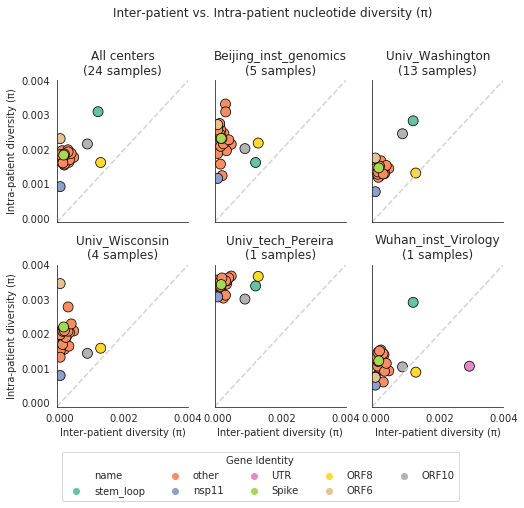

In [110]:
Fdb = MGdb.copy()
Fdb = Fdb[Fdb['Run'] != 'all']
Fdb = pd.merge(Fdb, PMdb[['Run', 'Center_ID']], on='Run')

LIM = 0.004
NLIM = -0.0001

g2c = {'S':'Spike', 'ORF10':'ORF10', 'ORF8':'ORF8', 'stem_loop':'stem_loop', "YP_009725312.1":'nsp11', 'ORF6':'ORF6', '5\'UTR':'UTR'}


# Set up axes
X_LEN = 2
Y_LEN = int((len(Fdb['Center_ID'].unique()) + 1) / X_LEN)
print("{0} by {1}".format(Y_LEN, X_LEN))
fig, axs = plt.subplots(X_LEN, Y_LEN, sharex=True, sharey=True, gridspec_kw={"hspace": 0.3})
plt.gcf().set_size_inches(8, 6)

# Make a list of axes
ax_list = []
for ax in axs:
    for a in ax:
        ax_list.append(a)

# Do the all
ax = ax_list[0]

fdb = Fdb.copy()

# Get average average intra-patient gene diversity
fdb = fdb.groupby('gene')['normalized_microdiversity'].mean().to_frame().reset_index(drop=False).rename(columns={'normalized_microdiversity':'intrapatient_diversity'})

# Get average inter-patient diversity
ffdb = PGdb
ffdb = ffdb[['gene', 'diversity']].rename(columns={'diversity':'interpatient_diversity'})

# Merge
fdb = pd.merge(fdb, ffdb, on='gene', how='outer')

# Re-name
fdb['name'] = fdb['gene'].map(g2c).fillna('other')
fdb = fdb.sort_values('name', ascending=False)

# Plot


sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity', hue='name', s=100, edgecolor='black', ax=ax)
ax.plot([NLIM,LIM], [NLIM,LIM], c='lightgrey', ls='--')#, ax=ax)#, dpi=200)

ax.set_xlim(NLIM, LIM)
ax.set_ylim(NLIM, LIM)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Inter-patient diversity (π)')
ax.set_ylabel('Intra-patient diversity (π)')

center = 'All centers'
ax.set_title("{0}\n({1} samples)".format(center, len(Fdb['Run'].unique())))

ax.get_legend().remove()

i = 1
for center, fdb in Fdb.groupby('Center_ID'):
    ax = ax_list[i]

    # Get average average intra-patient gene diversity
    fdb = fdb.groupby('gene')['normalized_microdiversity'].mean().to_frame().reset_index(drop=False).rename(columns={'normalized_microdiversity':'intrapatient_diversity'})

    # Get average inter-patient diversity
    ffdb = PGdb
    ffdb = ffdb[['gene', 'diversity']].rename(columns={'diversity':'interpatient_diversity'})

    # Merge
    fdb = pd.merge(fdb, ffdb, on='gene', how='outer')

    # Re-name
    fdb['name'] = fdb['gene'].map(g2c).fillna('other')
    fdb = fdb.sort_values('name', ascending=False)

    # Plot

    sns.scatterplot(data=fdb, x='interpatient_diversity', y='intrapatient_diversity', hue='name', s=100, edgecolor='black', ax=ax)
    ax.plot([NLIM,LIM], [NLIM,LIM], c='lightgrey', ls='--')#, ax=ax)#, dpi=200)

    ax.set_xlim(NLIM, LIM)
    ax.set_ylim(NLIM, LIM)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel('Inter-patient diversity (π)')
    ax.set_ylabel('Intra-patient diversity (π)')
    
    ax.set_title("{0}\n({1} samples)".format(center, len(Fdb[Fdb['Center_ID'] == center]['Run'].unique())))
    
    if i != 3:
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower left', bbox_to_anchor= (0.0, -0.7), ncol=5, title='Gene Identity')
    
    i += 1
    
plt.suptitle('Inter-patient vs. Intra-patient nucleotide diversity (π)', y=1.05)
plt.gcf().savefig(save_loc + 'GeneMicrodiversity_scatter_interIntra_v3.png'.format(MIN_COV), bbox_inches='tight', dpi=200)
plt.show()